## _**Librerías**_

In [1]:
from mpi4py import MPI # Message Passing Interface
from petsc4py import PETSc # Library for solving PDE's assosiated linear problems
import dolfinx # FeniCSx Interface

import numpy as np # Numpy, the classic

import ufl
from basix.ufl import element, mixed_element # Elements for the FEM
from dolfinx import default_real_type, fem, la # FEM library with the functions required for solving through FEM (for real values)
from dolfinx.fem import (
    Constant,
    Function,
    dirichletbc,
    extract_function_spaces, 
    form,
    functionspace,
    locate_dofs_topological,
    create_interpolation_data,
    assemble_scalar
) # Functions for defining variational problems and defining mathematical functions and constants
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting # Functions for creating the matrix problems
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary # Mesh creating functions
from ufl import div, dx, grad, inner # operand functions

## _**Función de malla**_

In [2]:
def crear_malla(n):
    return create_rectangle(MPI.COMM_WORLD, [np.array([0.0,0.0]), np.array([1.0,1.0])], [n,n], CellType.triangle)

## _**Funciones para condiciones de borde**_

In [3]:
def noslip_boundary(x):
    # Dado un punto x, retorna si su coordenada x[i] es cercana al valor dado después.
    # En este caso, muro izquierdo | muro derecho | muro inferior
    return np.isclose(x[0], 0.0) | np.isclose(x[0], 1.0) | np.isclose(x[1], 0.0)

def lid(x):
    # Muro superior
    return np.isclose(x[1], 1.0)

def lid_velocity_expression(x):
    # Retorna la velocidad u = (1,0)
    return np.stack((np.ones(x.shape[1]), np.zeros(x.shape[1])))

def corners(x):
    # detecta las esquinas. 
    return (np.isclose(x[0], 0.0) & np.isclose(x[1], 1.0)) | \
           (np.isclose(x[0], 1.0) & np.isclose(x[1], 1.0))

## _**Función de resolución**_

In [1]:
def calculate_sol(n: int, f0:list, mu: int, elem: str, grad_vec: int, grad_elem: int) -> tuple:
    """
    Calculates the solution of a lid-driven cavity flow for a stationary stokes flow in 2D 
    given the resolution n of the mesh, the element and grades for the vectorial and scalar elements.
    IMPORTANT: f0 is now set to (0,0). It needs work to be able to change it in the function
    """

    # -------------- Malla -------------- #
    msh = crear_malla(n)
    # ----------------------------------- #


    
    # --------------------------------------------- Elements --------------------------------------------- #
    if elem == "Taylor-Hood":
        P2 = element("Lagrange", msh.basix_cell(), grad_vec, shape=(msh.geometry.dim,), dtype=default_real_type) # P2  grad k 
        P1 = element("Lagrange", msh.basix_cell(), grad_elem, dtype=default_real_type) # P1 grad k-1 

    TH = mixed_element([P2, P1])
    W = functionspace(msh, TH)
    # ---------------------------------------------------------------------------------------------------- #

    
    
    # --------------------------------------- Boundary Conditions --------------------------------------- #
    W0 = W.sub(0) # Tomamos la parte del espacio mixto que corresponde a la velocidad
    Q, _ = W0.collapse() # Creamos este "nuevo" espacio de funciones correspondiente a la velocidad
    
    # no-slip boundary conditions
    noslip = Function(Q)  # Default = 0
    
    facets = locate_entities_boundary(msh, 1, noslip_boundary) # (msh, dim, marker)
    
    # Asignamos la condición de Dirichlet u = (0,0) a esos puntos hallados
    dofs = locate_dofs_topological((W0, Q), 1, facets)
    bc0 = dirichletbc(noslip, dofs, W0)

    # Lid-driven boundary condition u = (1,0) en y=1
    lid_velocity = Function(Q)
    lid_velocity.interpolate(lid_velocity_expression) # Interpola valores dados por lid_velocity_expression con funciones del espacio de funciones de Q
    facets = locate_entities_boundary(msh, 1, lid)
    
    dofs = locate_dofs_topological((W0, Q), 1, facets)
    bc1 = dirichletbc(lid_velocity, dofs, W0)
    
    # Lid-driven boundary condition u = (1,0) en las esquinas
    corner_bc = Function(Q)
    corner_bc.interpolate(lid_velocity_expression) # Interpola valores dados por lid_velocity_expression con funciones del espacio de funciones de Q
    facets = locate_entities_boundary(msh, 1, corners)

    dofs = locate_dofs_topological((W0, Q), 1, facets)
    bc2 = dirichletbc(corner_bc, dofs, W0)


    # Juntamos en una lista las condiciones de borde
    #bcs = [bc0,bc1, bc2]
    bcs = [bc0, bc1]

    # ----------------------------------------------------------------------------------------------------- #

    
    
    # ----------------------------Formulación variacional-------------------------------- #
    (u,p) = ufl.TrialFunctions(W) # Definimos las trial functions
    (v,q) = ufl.TestFunctions(W) # Definimos las test functions
    
    f = Function(Q) 
    #f.interpolate(f0)

    U = 1 # Characteristic velocity
    L = 1 # Characteristic lenght
    rho = 1e-6

    nu = mu/rho
    Re = PETSc.ScalarType((U*L)/nu)

    # Forma bilineal
    a = form(PETSc.ScalarType(mu)*(inner(grad(u), grad(v)) + inner(p, div(v)) + inner(div(u), q))* dx )
    
    # Forma lineal
    L = form(inner(f,v) * dx)

    # ------------------------------------------------------------------------------------ #



    # ------------------------------------ Resolución del problema ------------------------------------ #
    # Armamos la matriz A de la forma bilinear
    A = assemble_matrix(a, bcs=bcs)
    A.assemble()
    
    # Armamos el vector b de la forma linear
    b = assemble_vector(L)
    
    # "Ajustamos" b para que se mantenga la igualad Ax = b luego de aplicarle las bcs a A
    apply_lifting(b, [a], bcs=[bcs])
    
    # Sincroniza los "Ghost values" usados para la computación paralela
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE) # ???
    
    # Aplicamos las condiciones de borde a b
    for bc in bcs:
        bc.set(b)

    # Configuramos el solver (Kyrlov SubsPace method)
    ksp = PETSc.KSP().create(msh.comm) # msh.comm es el MPI communicator que permite computación paralela
    ksp.setOperators(A) # Define la matriz A del sistema
    #ksp.setType("cg") # Aplica el precondicionador 1 sola vez para el direct solver
    ksp.setType("preonly")

    # Configuramos MUMPS para que maneje el espacio nulo de la presión
    # MUMPS: MUltifrontal Massively Parallel sparse direct Solver
    pc = ksp.getPC() # Precondicionador de ksp
    pc.setType("lu") # El preocondicionador a usar (de LU)
    
    pc.setFactorSolverType("mumps") 
    pc.setFactorSetUpSolverType()
    pc.getFactorMatrix().setMumpsIcntl(icntl=24, ival=1)
    pc.getFactorMatrix().setMumpsIcntl(icntl=25, ival=0)
    
    pc.setFactorSolverType("superlu_dist") # Establece el tipo de solver

    # Resolución
    U = Function(W)
    ksp.solve(b, U.x.petsc_vec)

    u, p = U.sub(0).collapse(), U.sub(1).collapse()

    # ------------------------------------------------------------------------------------------------- #

    return u, p, W

## _**Convergencia**_

### _Calculation of solutions_

In [5]:
total = 6
sizes = [2**(i+3) for i in range(total)]
elem = "Taylor-Hood"
f0 = [0,0]
mu = 1
k = 2

u_h_list = [0 for i in range(total)]
p_h_list = [0 for i in range(total)]
W_h_list = [0 for i in range(total)]


for i in range(total):
    n = sizes[i]
    print(f"Calulating solution for n = {n}...")
    u, p, W = calculate_sol(n, f0, mu, elem, k, k-1)
    u_h_list[i] = u
    p_h_list[i] = p
    W_h_list[i] = W
    print("Solved!")

Calulating solution for n = 8...
Solved!
Calulating solution for n = 16...
Solved!
Calulating solution for n = 32...
Solved!
Calulating solution for n = 64...
Solved!
Calulating solution for n = 128...
Solved!
Calulating solution for n = 256...
Solved!


### _Error norm function_

In [6]:
def norm(norm_type: str ,u_ex: dolfinx.fem.function.Function, V_ex: dolfinx.fem.function.FunctionSpace, u_h :dolfinx.fem.function.Function, V_h: dolfinx.fem.function.FunctionSpace, cells_fine: np.ndarray):
    """
    Calculates the error norm between a "exact" solution and a approximated solution to a 
    PDE calculated through the FEM given the solutions and their respective functions spaces
    """
    
    # ----------------------------- mesh interpolation ----------------------------- #
    # Interpolamos la solución aproximada sobre la malla fina
    u_h_coarse_to_fine = Function(V_ex)  # Nueva función en la malla fina
    interpolation_data = create_interpolation_data(V_ex, V_h, cells_fine)  # Datos para interpolar entre espacios no coincidentes
    u_h_coarse_to_fine.interpolate_nonmatching(u_h, cells_fine, interpolation_data=interpolation_data)  # Interpolación
    u_h_coarse_to_fine.x.scatter_forward()  # Sincroniza datos entre procesos
    # ------------------------------------------------------------------------------ #


    # ------------------------------ Error ------------------------------ #
    e = u_ex - u_h_coarse_to_fine

    # If scalar (pressure), subtract mean before error calculation
    if str(u_ex.function_space.ufl_element()) == "Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])":  # Scalar field
        u_ex.x.array[:] -= np.mean(u_ex.x.array)
        u_h_coarse_to_fine.x.array[:] -= np.mean(u_h_coarse_to_fine.x.array)
        
    if norm_type == "L2":
        error = form((inner(e,e))* dx) # Formamos la integral
        error_local = assemble_scalar(error) # calculamos la integral
        return np.sqrt(V_ex.mesh.comm.allreduce(error_local, op=MPI.SUM)) # Sumamos los errores en cada punto

    elif norm_type == "H1":
        error = form((inner(e,e) + inner(grad(e),grad(e)))* dx) # Formamos la integral
        error_local = assemble_scalar(error) # calculamos la integral
        return np.sqrt(V_ex.mesh.comm.allreduce(error_local, op=MPI.SUM)) # Sumamos los errores en cada punto
    # ------------------------------------------------------------------- #


### _**Convergence Rate**_

In [7]:
u_ex = u_h_list[-1]
p_ex = p_h_list[-1]
W_ex = W_h_list[-1]
V_ex, _ = W_ex.sub(0).collapse()

cells_fine_map = V_ex.mesh.topology.index_map(V_ex.mesh.topology.dim)
num_cells_on_proc_fine = cells_fine_map.size_local + cells_fine_map.num_ghosts
cells_fine_u = np.arange(num_cells_on_proc_fine, dtype=np.int32)

Q_ex, _ = W_ex.sub(1).collapse()

cells_fine_map = Q_ex.mesh.topology.index_map(Q_ex.mesh.topology.dim)
num_cells_on_proc_fine = cells_fine_map.size_local + cells_fine_map.num_ghosts
cells_fine_p = np.arange(num_cells_on_proc_fine, dtype=np.int32)

total -= 1

h = np.array([1/n for n in sizes][:total])


### Velocidad

#### _L2 norm_

In [8]:
# Interpolamos cada solución sobre la malla fina
norm_type = "L2"
error_L2_u = np.array([0. for i in range(total)])

for i in range(total):
    u_h = u_h_list[i]
    W_h = W_h_list[i]
    V_h, _ = W_h.sub(0).collapse()
    
    error_L2_u[i] = norm(norm_type,u_ex, V_ex, u_h, V_h, cells_fine_u)


In [9]:
x_ref = 1/h[:total]
y0 = error_L2_u[-2]
x0 = x_ref[-2]
asintota = y0 * (x_ref/x0)**(-2)

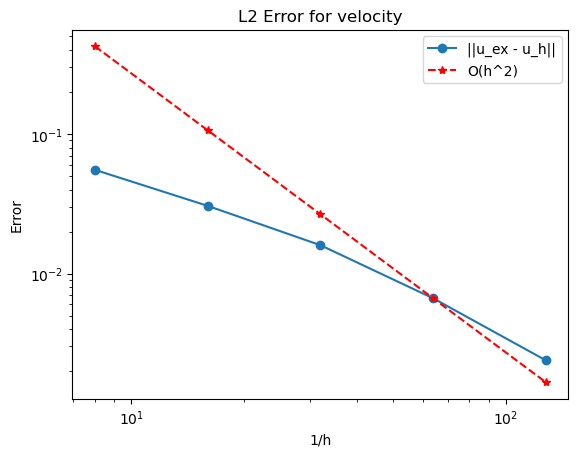

In [10]:
import matplotlib.pyplot as plt

plt.loglog(1/h[:total], error_L2_u, "o-", label= "||u_ex - u_h||")
plt.loglog(x_ref, asintota, "r*--", label="O(h^2)")
plt.legend(loc="upper right")
plt.title(f"{norm_type} Error for velocity")
plt.xlabel("1/h")
plt.ylabel("Error")
plt.show()

In [11]:
Slope, intercept = np.polyfit(np.log(1/h[total-2:total]), np.log(error_L2_u[total-2:]), 1)
print(f"Tasa de convergencia en la norma {norm_type} = {-Slope}")

Tasa de convergencia en la norma L2 = 1.4781709912789383


#### _H1 norm_

In [12]:
# Interpolamos cada solución sobre la malla fina
norm_type = "H1"

error_H1_u = np.array([0. for i in range(total)])

for i in range(total):
    u_h = u_h_list[i]
    W_h = W_h_list[i]
    V_h, _= W_h.sub(0).collapse()

    error_H1_u[i] = norm(norm_type,u_ex, V_ex, u_h, V_h, cells_fine_u)

In [13]:
x_ref = 1/h[:total]
y0 = error_H1_u[-2]
x0 = x_ref[-2]
asintota = y0 * (x_ref/x0)**(-1)

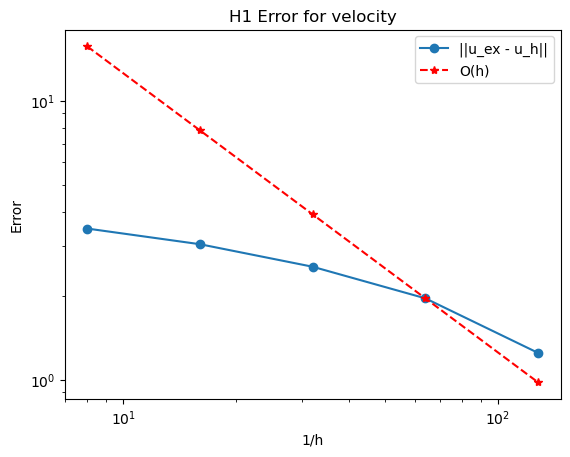

In [14]:
import matplotlib.pyplot as plt

plt.loglog(1/h[:total], error_H1_u, "o-", label= "||u_ex - u_h||")
plt.loglog(x_ref, asintota, "r*--", label="O(h)")
plt.legend(loc="upper right")
plt.title(f"{norm_type} Error for velocity")
plt.xlabel("1/h")
plt.ylabel("Error")
plt.show()

In [15]:
Slope, intercept = np.polyfit(np.log(1/h[total-2:total]), np.log(error_H1_u[total-2:]), 1)
print(f"Tasa de convergencia en la norma {norm_type} = {-Slope}")

Tasa de convergencia en la norma H1 = 0.6495297255369445


### Presión

In [16]:
# Interpolamos cada solución sobre la malla fina
norm_type = "L2"
error_L2_p = np.array([0. for i in range(total)])

for i in range(total):
    p_h = p_h_list[i]
    W_h = W_h_list[i]
    Q_h, _= W_h.sub(1).collapse()
    
    error_L2_p[i] = norm(norm_type,p_ex, Q_ex, p_h, Q_h, cells_fine_p)

In [17]:
x_ref = 1/h[:total]
y0 = error_L2_p[-2]
x0 = x_ref[-2]
asintota = y0 * (x_ref/x0)**(-1) 

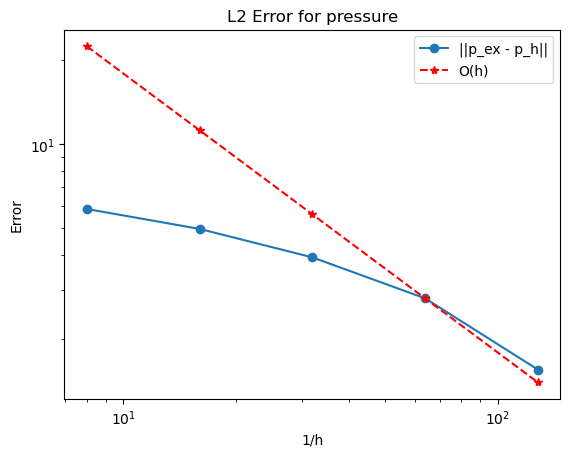

In [18]:
import matplotlib.pyplot as plt

plt.loglog(1/h[:total], error_L2_p, "o-", label= "||p_ex - p_h||")
plt.loglog(x_ref, asintota, "r*--", label="O(h)")
plt.legend(loc="upper right")
plt.title(f"{norm_type} Error for pressure")
plt.xlabel("1/h")
plt.ylabel("Error")
plt.show()

In [19]:
Slope, intercept = np.polyfit(np.log(1/h[total-2:total]), np.log(error_L2_p[total-2:]), 1)
print(f"Tasa de convergencia en la norma {norm_type} = {-Slope}")

Tasa de convergencia en la norma L2 = 0.8477418265191478
